# Пример расчета показателя Value - at - risk.

## Описание:

Показатель Value at risk является одним из наиболее широко применяемых для оценки рыночного риска.

Рассчитаем показатель VaR на основе исторического и параметрического подходов. Кроме того, рассчитаем показатель Conditional VaR.

## Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

## Зададим константу (наименования столбцов в импортируемом файле)

In [3]:
COLUMNS = ['TICKER', 'PER', 'DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']

## Зададим пользовательскте функции

#### Функция парсинга и предобработки файла

In [4]:
def parse_and_preprocess(path):
    data = pd.read_csv(path)
    data.columns = COLUMNS
    data['DATE'] = pd.to_datetime(data['DATE'], format = '%Y%m%d')
    data.sort_values(by = 'DATE', inplace=True)
    data.set_index('DATE', drop = True, inplace=True)
    return data

#### Функция первичного обзора файла

In [5]:
def init_observ(data):
    print('Выведем датафрейм на экран:')
    display(data)
    print('Сводная информация по датафрейму:')
    data.info()
    print('Проверим наличие пропусков данных:')
    print(data.isna().sum())
    print('Распечатаем график цен закрытия:')
    data['CLOSE'].plot(figsize = (15, 9))
    plt.show()

## Загрузка и обзор данных

### ВТБ

#### Загрузка

In [6]:
vtb = parse_and_preprocess('VTBR_200101_230308.csv')

#### Обзор датафрейма

Выведем датафрейм на экран:


,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL
DATE,,,,,,,,
2020-01-03,VTBR,D,0,0.046105,0.046340,0.045995,0.046240,11882340000
2020-01-06,VTBR,D,0,0.046110,0.046195,0.045930,0.046110,7975960000
2020-01-08,VTBR,D,0,0.046210,0.047000,0.046200,0.046525,28637340000
2020-01-09,VTBR,D,0,0.046820,0.047300,0.046575,0.047075,29466080000
2020-01-10,VTBR,D,0,0.047120,0.047890,0.047005,0.047600,29871600000
...,...,...,...,...,...,...,...,...
2023-03-02,VTBR,D,0,0.016645,0.016725,0.016235,0.016405,40073750000
2023-03-03,VTBR,D,0,0.016430,0.016600,0.016385,0.016585,22263850000
2023-03-06,VTBR,D,0,0.016645,0.016810,0.016630,0.016770,30677970000


Сводная информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 785 entries, 2020-01-03 to 2023-03-09
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  785 non-null    object 
 1   PER     785 non-null    object 
 2   TIME    785 non-null    int64  
 3   OPEN    785 non-null    float64
 4   HIGH    785 non-null    float64
 5   LOW     785 non-null    float64
 6   CLOSE   785 non-null    float64
 7   VOL     785 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 55.2+ KB
Проверим наличие пропусков данных:
TICKER    0
PER       0
TIME      0
OPEN      0
HIGH      0
LOW       0
CLOSE     0
VOL       0
dtype: int64
Распечатаем график цен закрытия:


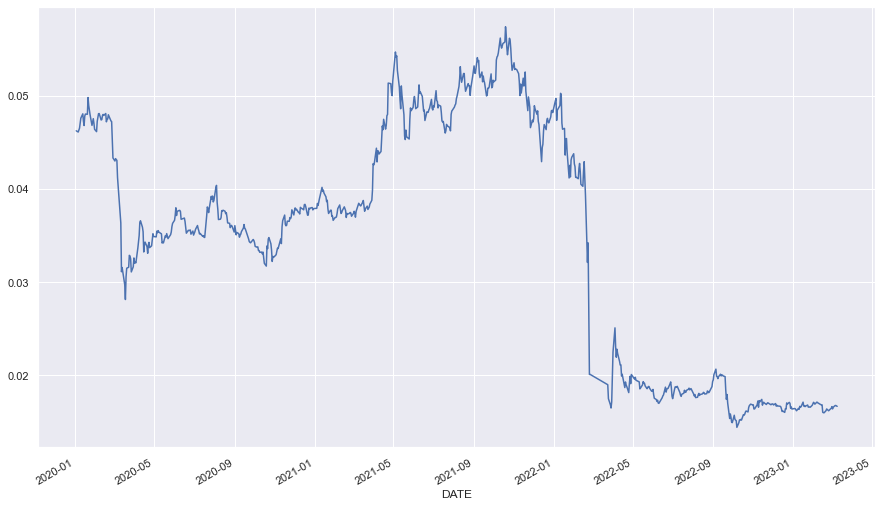

In [7]:
init_observ(vtb)

## Расчет дневных доходностей

In [8]:
vtb['returns'] = vtb['CLOSE'].pct_change()

## Оставим только те дни, за которые имеются котировки.

In [9]:
vtb = vtb.dropna()

## Переходим к расчету показателя непараметрический (исторический) VaR.

Зададим доверительный уровень.

In [10]:
var_level = 95

Рассчитаем показатель стоимости под риском для заданного интервала.

In [11]:
var_95 = vtb['returns'].quantile((100 - var_level) / 100)

In [12]:
print('VaR({}) = {:.4f}'.format(var_level, var_95))

VaR(95) = -0.0384


Данный показатель интерпретируется следующим образом: в 95% случаев убытки за один день не превысят указанную выше величину.

С применением полученного выше значения рассчитаем Conditional VaR: математическое ожидание (средняя величина) убытков в оставшихся пяти процентах случаев (в нашем примере). 

In [13]:
cvar_95 = vtb.loc[vtb['returns'] <= var_95, 'returns'].mean()

In [14]:
print('СVaR({}) = {:.4f}'.format(var_level, cvar_95))

СVaR(95) = -0.0679


Данный показатель интерпретируется следующим образом: в оставшихся 5% случаев, когда убытки за один день превышают величину VaR, можем в среднем ожидать убытков в размере CVaR.

## Параметрический VaR.

Параметрический VaR исходит из предположения о нормальности распределения дневных доходностей и позволяет рассчитать показатель VaR, применив свойства нормального распределения.

Задаем значение средней дневной доходности.

In [15]:
mu = vtb['returns'].mean()

Задаем значение стандартного отклонения дневных доходностей.

In [16]:
std = vtb['returns'].std()

Используем var_level заданный выше.

In [17]:
VaR = norm.ppf((100 - var_level) / 100, mu, std)

In [18]:
print('Parametric VaR({}) = {:.4f}'.format(var_level, VaR))

Parametric VaR(95) = -0.0472


Интерпретация аналогична VaR.

## Выведем гистограмму распределения дневных доходностей с нанесенными уровнями VaR, CVaR и Parametric VaR.

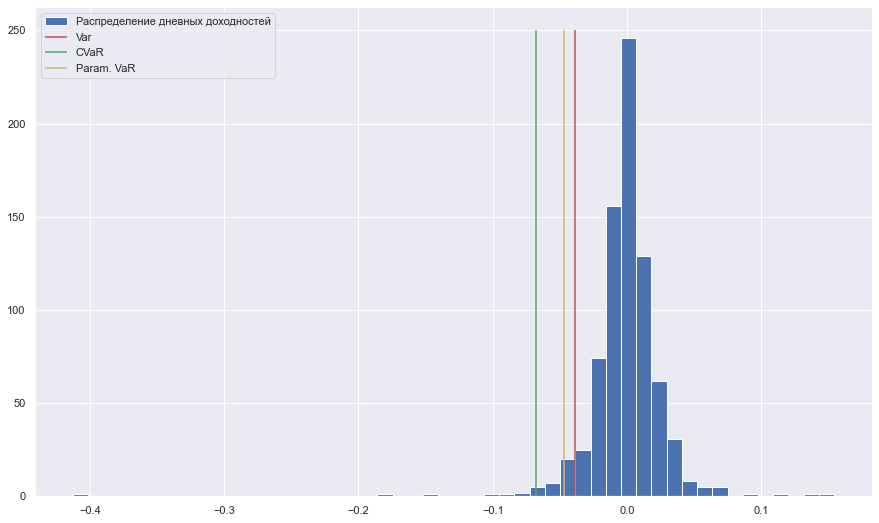

In [19]:
plt.figure(figsize=(15, 9))
vtb['returns'].hist(bins = 50, label = 'Распределение дневных доходностей')
plt.vlines(var_95, 0, 250, color = 'r', label = 'Var')
plt.vlines(cvar_95, 0, 250, color = 'g', label = 'CVaR')
plt.vlines(VaR, 0, 250, color = 'y', label = 'Param. VaR')
plt.legend()
plt.show()

## Пример применения.

In [20]:
prt_sum = 100000000

In [21]:
risk = prt_sum * (var_95)

In [22]:
print('{:.2f}'.format(risk))

-3843143.81


Предположим, лимит на акции ВТБ составляет 100 млн руб. Проведенный расчет показывает, что в 95% случаев величина потерь не превысит 3,84 млн руб (на горизонте один день).

In [23]:
exp_loss = prt_sum * (cvar_95)

In [24]:
print('{:.2f}'.format(exp_loss))

-6794027.13


В оставшихся 5% случаев ожидаемый (средний) размер потерь составит 6,8 млн руб. Расчеты проведены на основе исторического подхода к оцениванию VaR.

In [25]:
param_risk = prt_sum * (VaR)

In [26]:
print('{:.2f}'.format(param_risk))

-4722821.74


С применением параметрического VaR получим оценку, портфель первоначальной стоимостью 100 млн руб в течение дня с вероятность 95% не потеряет в цене более 4,72 млн руб.

## Выводы:

Привели методику расчета показателя стоимости под риском с применением нескольких подходов.

Привели пример применения для оценки риска портфеля.